In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.metrics import fbeta_score
from tqdm import tqdm
import tensorflow as tf
from keras import optimizers
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input , Dense , Dropout , Flatten,\
Conv2D,MaxPooling2D , BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
import tensorflow_addons as tfa

In [2]:
path = "../input/planets-dataset/planet/planet"
os.listdir(path)

['sample_submission.csv', 'test-jpg', 'train_classes.csv', 'train-jpg']

In [3]:
# read csv file and display top five records from the dataset
train_data = pd.read_csv(os.path.join(path,"train_classes.csv"))
train_data.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
np_tags = train_data['tags'].to_numpy()
unique_tags = list()
for tags in np_tags:
    labels = tags.split()
    for label in labels:
        if label not in unique_tags:
            unique_tags.append(label)
print(unique_tags)
print("There are {} unique tags in the train data".format(len(unique_tags)))

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy', 'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming', 'selective_logging', 'blow_down']
There are 17 unique tags in the train data


In [5]:
# hot-encoding the 'tags' column
for unique_tag in unique_tags:
    train_data[unique_tag]=train_data["tags"].apply(lambda x: 1 if unique_tag in x.split() else 0)
train_data.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [6]:
# feeding relevant columns into the generator
rel_cols = train_data.columns.to_list()[2:] 
train_dir = os.path.join(path,'train-jpg')

## Renaming the `image_name` column contents to use `ImageDataGenerator`

In [7]:
train_data['image_name'] = train_data['image_name'].apply(lambda x: x+".jpg")
train_data.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,slash_burn,cloudy,partly_cloudy,conventional_mine,bare_ground,artisinal_mine,blooming,selective_logging,blow_down
0,train_0.jpg,haze primary,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,train_1.jpg,agriculture clear primary water,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3.jpg,clear primary,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4.jpg,agriculture clear habitation primary road,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [8]:
train_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

# train_set contains 80 percent of images
train_gen = train_generator.flow_from_dataframe(dataframe=train_data,
                                              directory = train_dir,  
                                              x_col="image_name", 
                                              y_col=rel_cols, 
                                              subset="training", 
                                              batch_size=128,
                                              seed=42, 
                                              shuffle = True, 
                                              class_mode="raw", 
                                              target_size=(128,128))


# val_set contains 20 percent of images 
val_gen = train_generator.flow_from_dataframe(dataframe=train_data,
                                            directory = train_dir,  
                                            x_col="image_name", 
                                            y_col=rel_cols, 
                                            subset="validation", 
                                            batch_size=128,
                                            seed=42, 
                                            shuffle = True, 
                                            class_mode="raw", 
                                            target_size=(128,128))

Found 32384 validated image filenames.
Found 8095 validated image filenames.


In [9]:
gc.collect()

1449

In [10]:
model = Sequential()

# input layer
model.add(BatchNormalization(input_shape=(128, 128, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# hidden layers
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(17, activation='sigmoid'))

2023-01-17 21:37:53.058264: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 21:37:53.146425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 21:37:53.147266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-17 21:37:53.149353: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
train_steps = train_gen.n // train_gen.batch_size
val_steps = val_gen.n // train_gen.batch_size

In [12]:
def fbeta_score(y_true, y_pred, beta = 2, epsilon = 1e-4):
    beta_squared = beta**2
    
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    precision = tp/(tp +fp +epsilon)
    recall = tp/(tp + fn + epsilon)
    
    return (1 + beta_squared) * precision * recall / (beta_squared * precision + recall + epsilon)
def accuracy(y_true, y_pred, epsilon = 1e-4):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(tf.greater(tf.cast(y_pred, tf.float32), tf.constant(0.5)), tf.float32)
    
    tp = tf.reduce_sum(y_true * y_pred, axis = 1)
    fp = tf.reduce_sum(y_pred, axis = 1) - tp
    fn = tf.reduce_sum(y_true, axis = 1) - tp
    
    y_true = tf.cast(y_true, tf.bool)
    y_pred = tf.cast(y_pred, tf.bool)
        
    tn = tf.reduce_sum(tf.cast(tf.logical_not(y_true), tf.float32) * tf.cast(tf.logical_not(y_pred), tf.float32),                 axis = 1)
    return (tp + tn)/(tp + tn + fp + fn + epsilon)

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[fbeta_score,accuracy])

# Save the callback
callback = EarlyStopping(
    monitor="val_loss", 
    patience=2,
    verbose=0,
    baseline=None,
    restore_best_weights=True,
)

In [14]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [15]:
history = model.fit(x=train_gen,
                    steps_per_epoch=train_steps,
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=20,
                    callbacks=[callback]) 

2023-01-17 21:40:58.265353: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2023-01-17 21:41:01.080221: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


253/253 [==============================] - 261s 997ms/step - loss: 0.2290 - fbeta_score: 0.6849 - accuracy: 0.9129 - val_loss: 0.2153 - val_fbeta_score: 0.6932 - val_accuracy: 0.9171
Epoch 2/20
253/253 [==============================] - 100s 397ms/step - loss: 0.1658 - fbeta_score: 0.7823 - accuracy: 0.9349 - val_loss: 0.1504 - val_fbeta_score: 0.7952 - val_accuracy: 0.9399
Epoch 3/20
253/253 [==============================] - 104s 411ms/step - loss: 0.1486 - fbeta_score: 0.8040 - accuracy: 0.9409 - val_loss: 0.1359 - val_fbeta_score: 0.8120 - val_accuracy: 0.9444
Epoch 4/20
253/253 [==============================] - 105s 414ms/step - loss: 0.1397 - fbeta_score: 0.8190 - accuracy: 0.9447 - val_loss: 0.1308 - val_fbeta_score: 0.8394 - val_accuracy: 0.9494
Epoch 5/20
253/253 [==============================] - 107s 422ms/step - loss: 0.1346 - fbeta_score: 0.8299 - accuracy: 0.9468 - val_loss: 0.1257 - val_fbeta_score: 0.8361 - val_accuracy: 0.9499
Epoch 6/20
253/253 [=====================

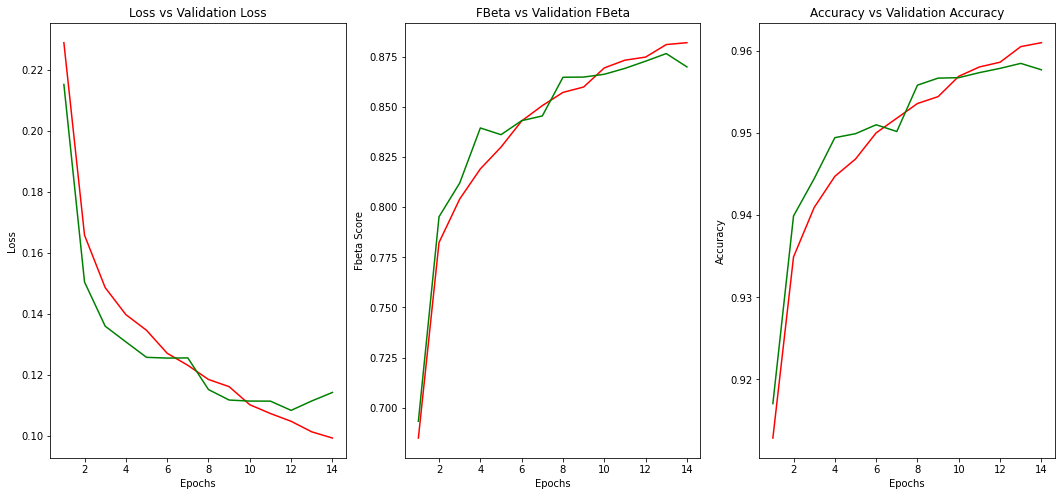

In [16]:
hist_dict = history.history
loss = hist_dict['loss']
val_loss=hist_dict["val_loss"]

fbeta = hist_dict['fbeta_score']
val_fbeta = hist_dict['val_fbeta_score']

acc = hist_dict['accuracy']
val_acc = hist_dict['val_accuracy']

epochs = range(1,1+len(acc))
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(18,8))
ax1.plot(epochs,loss, label='Loss', color = 'red')
ax1.plot(epochs,val_loss,label='Validation Loss', color = 'green')
ax1.set_title('Loss vs Validation Loss')
ax1.set_ylabel('Loss')


ax2.plot(epochs,fbeta,label='FBeta', color = 'red')
ax2.plot(epochs,val_fbeta,label='Validation FBeta', color = 'green')
ax2.set_title('FBeta vs Validation FBeta')
ax2.set_ylabel('Fbeta Score')

ax3.plot(epochs,acc,label='Accuracy', color = 'red')
ax3.plot(epochs,val_acc,label='Validation Accuracy', color = 'green')
ax3.set_title('Accuracy vs Validation Accuracy')
ax3.set_ylabel('Accuracy')

for x in (ax1,ax2,ax3):
    x.set_xlabel('Epochs')
plt.show()

In [17]:
submission_df = pd.read_csv(os.path.join(path,'sample_submission.csv'))
test_df = submission_df.iloc[:40669]['image_name'].reset_index().drop('index', axis =1)

test_df['image_name'] = submission_df['image_name'].apply(lambda x: x+'.jpg')
test_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [18]:
test_generator = ImageDataGenerator(rescale = 1./255)

test_gen = test_generator.flow_from_dataframe(dataframe=test_df,
                                            directory = os.path.join(path,'test-jpg'),  
                                            x_col="image_name", 
                                            y_col=None, 
                                            batch_size=67,
                                            shuffle=False,
                                            class_mode=None, 
                                            target_size=(128,128))

test_size = test_gen.n // test_gen.batch_size

Found 40669 validated image filenames.


In [19]:
pred = model.predict(test_gen, steps=test_size, verbose=1)

607/607 [==============================] - 248s 408ms/step


In [20]:
test_names = test_gen.filenames 
        
test_result = pd.DataFrame(pred)
test_result = test_result.apply(lambda x: ' '.join(np.array(unique_tags)[x >= 0.2]), axis=1)

test_result_df = pd.DataFrame({'image_name': test_names, 'tags': test_result})
test_result_df.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear partly_cloudy
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary agriculture clear cultivation
4,test_4.jpg,primary cloudy partly_cloudy


In [21]:
additional_df = submission_df.iloc[40669:]['image_name'].reset_index().drop('index', axis=1)

In [22]:
additional_df['image_name'] = additional_df['image_name'].apply(lambda x: '{}.jpg'.format(x))
additional_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [23]:
additional_gen = test_generator.flow_from_dataframe(dataframe=additional_df,
                                                  directory="../input/planets-dataset/test-jpg-additional/test-jpg-additional", 
                                                  x_col='image_name',
                                                  y_col = None,
                                                  batch_size=62,
                                                  shuffle=False,
                                                  class_mode=None, 
                                                  target_size=(128, 128))


additional_step = additional_gen.n // additional_gen.batch_size

Found 20522 validated image filenames.


In [24]:
pred_additional = model.predict(additional_gen, steps=additional_step, verbose=1)

331/331 [==============================] - 130s 393ms/step


In [25]:
additional_names = additional_gen.filenames 
        
additional_result = pd.DataFrame(pred_additional)
additional_result = additional_result.apply(lambda x: ' '.join(np.array(unique_tags)[x >= 0.2]), axis=1)

additional_result_df = pd.DataFrame({'image_name': additional_names, 'tags': additional_result})
additional_result_df.head()

,image_name,tags
0,file_0.jpg,primary clear
1,file_1.jpg,primary agriculture water habitation road part...
2,file_10.jpg,haze primary agriculture clear water road
3,file_100.jpg,primary agriculture clear water
4,file_1000.jpg,primary clear


In [26]:
final_df = pd.concat([test_result_df, additional_result_df])
final_df = final_df.reset_index().drop('index', axis =1)
final_df

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear partly_cloudy
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary agriculture clear cultivation
4,test_4.jpg,primary cloudy partly_cloudy
...,...,...
61186,file_9995.jpg,primary cloudy partly_cloudy
61187,file_9996.jpg,primary agriculture clear water
61188,file_9997.jpg,primary clear water
61189,file_9998.jpg,haze primary cloudy


In [27]:
final_df['image_name'] = final_df['image_name'].apply(lambda x: x.replace('.jpg',''))
final_df

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear partly_cloudy
2,test_2,primary partly_cloudy
3,test_3,primary agriculture clear cultivation
4,test_4,primary cloudy partly_cloudy
...,...,...
61186,file_9995,primary cloudy partly_cloudy
61187,file_9996,primary agriculture clear water
61188,file_9997,primary clear water
61189,file_9998,haze primary cloudy


In [28]:
# submission file
final_df.to_csv('submission.csv', index=False)